In [1]:
from openbb import obb
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
obb.account.login(email = "your_email_here", password = "your_pw_here", remember_me = True)

In [16]:
data = obb.equity.price.historical("TSLA", start_date = "2000-01-01").to_df()

data.head(5)

,open,high,low,close,volume,vwap,label,adj_close,unadjusted_volume,change,change_percent,change_over_time
date,,,,,,,,,,,,
2010-06-29,1.27,1.67,1.17,1.59,281494500,1.48,"June 29, 10",1.59,281494500.0,0.32,25.20,0.2520
2010-06-30,1.72,2.03,1.55,1.59,257806500,1.72,"June 30, 10",1.59,257806500.0,-0.13,-7.56,-0.0756
2010-07-01,1.67,1.73,1.35,1.46,123282000,1.51,"July 01, 10",1.46,123282000.0,-0.21,-12.57,-0.1257
2010-07-02,1.53,1.54,1.25,1.28,77097000,1.36,"July 02, 10",1.28,77097000.0,-0.25,-16.34,-0.1634
2010-07-06,1.33,1.33,1.06,1.07,103003500,1.15,"July 06, 10",1.07,103003500.0,-0.26,-19.55,-0.1955


Cumulative Returns: $2139.08


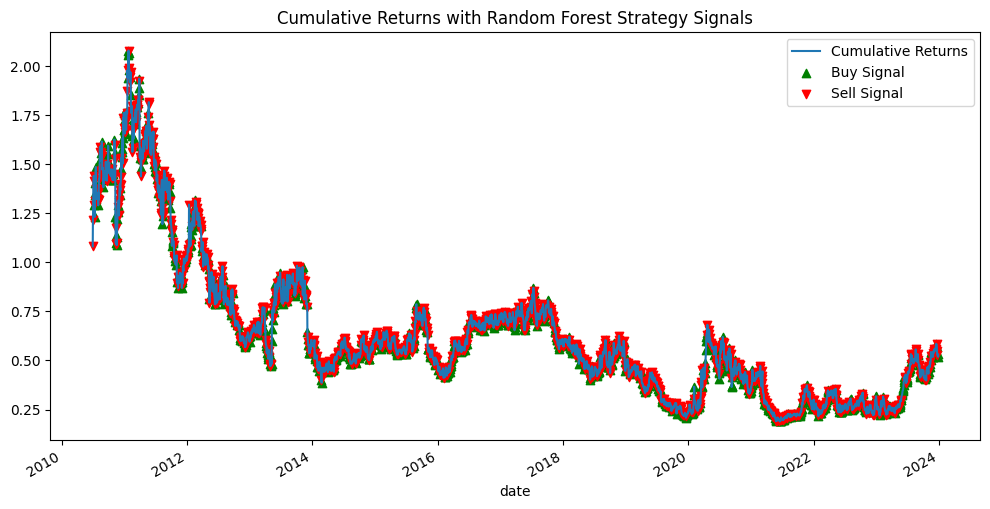

In [17]:
# Prepare data for Random Forest
data['Returns'] = data['close'].pct_change()
data.dropna(inplace=True)
X = data[['open', 'high', 'low', 'close']]
y = data['Returns'] > 0  # Classifying as positive or negative return

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create and fit Random Forest model
model = RandomForestClassifier(n_estimators=100)
model.fit(X_scaled, y)

# Generate trading signals (1 = buy, -1 = sell)
data['Signal'] = model.predict(X_scaled)
data['Signal'] = data['Signal'].map({True: 1, False: -1})

# Calculate strategy returns
data['Strategy_Returns'] = data['Returns'] * data['Signal'].shift(1)

# Calculate cumulative returns
data['Cumulative_Returns'] = (1 + data['Strategy_Returns']).cumprod()

# Output the cumulative returns value
cumulative_returns = data['Cumulative_Returns'].sum()
print(f"Cumulative Returns: ${cumulative_returns:.2f}")

# Plotting cumulative returns and signals for visualization
plt.figure(figsize=(12, 6))
data['Cumulative_Returns'].plot(label='Cumulative Returns')
plt.scatter(
    data[data['Signal'] == 1].index,
    data[data['Signal'] == 1]['Cumulative_Returns'],
    marker='^',
    color='g',
    label='Buy Signal',
    alpha=1
)
plt.scatter(
    data[data['Signal'] == -1].index,
    data[data['Signal'] == -1]['Cumulative_Returns'],
    marker='v',
    color='r',
    label='Sell Signal',
    alpha=1
)
plt.title('Cumulative Returns with Random Forest Strategy Signals')
plt.legend()
plt.show()